In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import os
import time
import datetime


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import config

In [2]:
#Load the Dataloader for this task
from DL_Autoencoder import DL_auto as DL

## Models

In [3]:




# Define your Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.ReLU()
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x





In [4]:
class Autoencoder2deeper(nn.Module):
    def __init__(self):
        super(Autoencoder2deeper, self).__init__()
        # Define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
        )
        
        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:

class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(16)
        self.dec_conv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = torch.sigmoid(self.dec_conv4(x))

        return x

In [6]:

class ResNetAutoencoder(nn.Module):
    def __init__(self,target_size=501):
        super(ResNetAutoencoder, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.target_size = target_size
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)  # Use Sigmoid for normalizing the output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, self.target_size))  # adapt to your target size
        return x
    

class ResNetAutoencoder_sig(nn.Module):
    def __init__(self, target_size=501):
        super(ResNetAutoencoder_sig, self).__init__()

        # Load pre-trained ResNet-50
        resnet = models.resnet50(pretrained=True)

        # Remove the fully connected layers
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        self.target_size = target_size
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Use Sigmoid for normalizing the output to [0,1]
            # nn.Tanh()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.adaptive_avg_pool2d(x, (128, self.target_size))  # adapt to your target size
        return x


In [7]:


class Autoencoder2deeperDO(nn.Module):
    def __init__(self):
        super(Autoencoder2deeperDO, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.enc_conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.enc_conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.5)

        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn1 = nn.BatchNorm2d(128)
        self.dec_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn2 = nn.BatchNorm2d(64)
        self.dec_conv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn3 = nn.BatchNorm2d(32)
        self.dec_conv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.dec_bn4 = nn.BatchNorm2d(16)
        self.dec_conv5 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.enc_conv1(x)))
        x = F.relu(self.bn2(self.enc_conv2(x)))
        x = F.relu(self.bn3(self.enc_conv3(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn4(self.enc_conv4(x)))
        x = F.relu(self.bn5(self.enc_conv5(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dropout2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = F.relu(self.dec_bn4(self.dec_conv4(x)))
        x = torch.sigmoid(self.dec_conv5(x))

        return x


In [8]:
# initialize the DataLoader
train_loader, val_loader = DL.create_generators()

Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True


In [9]:
##Some parameters for the training
config.freq_mask_param = 36
config.time_mask_param = 90
config.desired_length_in_seconds = 7

## Test Plot of Maked and real Spectrogram

torch.Size([128, 438])
torch.Size([32, 3, 128, 438])


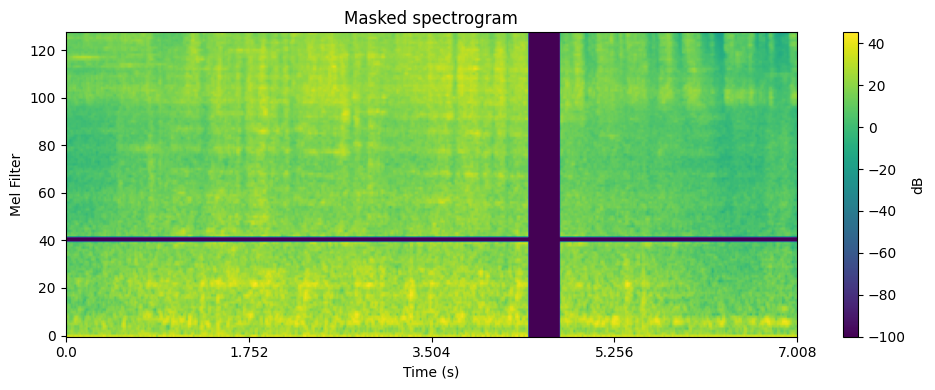

torch.Size([128, 438])
torch.Size([32, 3, 128, 438])


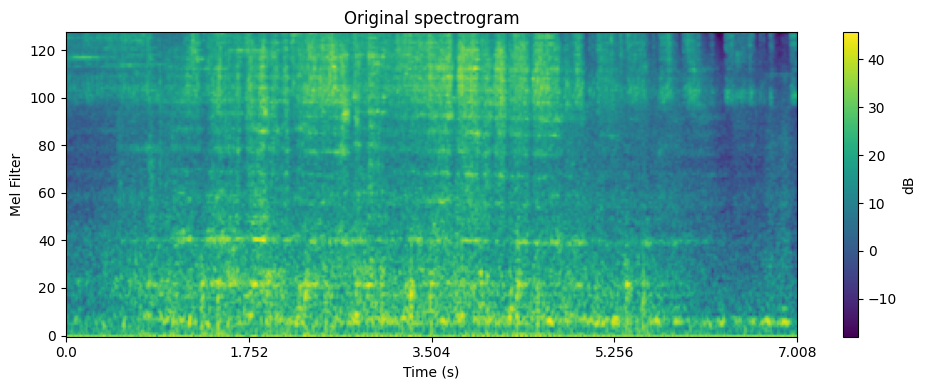

In [10]:
data1, data2 = next(iter(train_loader))

def plot_mel_spectrogram(melspe_db, sample_rate, hop_length, name):
    plt.figure(figsize=(10, 4))

    melspe_db_single = melspe_db[0, 0, :, :].squeeze()

    print(melspe_db_single.shape)
    print(melspe_db.shape)

    if melspe_db_single.ndim != 2:
        raise ValueError("melspe_db_single should be a 2D array")

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db_single.cpu().detach().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title(name)

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), 
               np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Call the function with the modified data
plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")

### Model initalisation

In [11]:
data1,_ = next(iter(train_loader))

# set the target size
target_size = data1.shape[3]
print(target_size)

# Instantiate model, loss function, and optimizer
#model = Autoencoder()
#model = Autoencoder2deeper()
#model = Autoencoder2deeperDO()
model = ResNetAutoencoder(target_size)
#model = ResNetAutoencoder_sig(target_size)
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Training loop
num_epochs = config.epochs



438


c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
#create res directory
res_dir = f'./results/res_auto/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}_auto'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

In [13]:

patience = config.patience 
best_val_loss = float('inf')  
epochs_no_improve = 0  
checkpoint_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for mel_spec_masked, mel_spec in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        mel_spec_masked = mel_spec_masked.to(device)
        mel_spec = mel_spec.to(device)

        optimizer.zero_grad()

        outputs = model(mel_spec_masked)
        _, _, H, W = outputs.size()
        mel_spec = mel_spec[..., :H, :W]

        loss = criterion(outputs, mel_spec)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel_spec_masked, mel_spec in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            mel_spec_masked = mel_spec_masked.to(device)
            mel_spec = mel_spec.to(device)

            outputs = model(mel_spec_masked)
            _, _, H, W = outputs.size()
            mel_spec = mel_spec[..., :H, :W]

            loss = criterion(outputs, mel_spec)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    #early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        epochs_no_improve = 0
        print(f'Best validation loss: {best_val_loss:.4f}')
        torch.save(model, f'{res_dir}/resNet_autoen_model{checkpoint_counter}.pth')
        checkpoint_counter += 1
    else:
        epochs_no_improve += 1
        print(f'Epochs with no improvement: {epochs_no_improve}')

    if epochs_no_improve == patience:
        print('Early stopping!' )
        break

    


    lr_scheduler.step(val_losses[-1])

    # Print losses
    print(f'Epoch {epoch+1}, Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}')

#save whole model
torch.save(model, f'{res_dir}/resNet_autoen_model_full.pth')

Epoch 1/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.67it/s]


Best validation loss: 71.4800
Epoch 1, Average Train Loss: 85.6209, Average Val Loss: 71.4800


Epoch 2/250 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.64it/s]


Best validation loss: 70.6828
Epoch 2, Average Train Loss: 78.4801, Average Val Loss: 70.6828


Epoch 3/250 - Validation: 100%|██████████| 139/139 [00:39<00:00,  3.53it/s]


Epochs with no improvement: 1
Epoch 3, Average Train Loss: 76.8131, Average Val Loss: 71.1217


Epoch 4/250 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.60it/s]


Best validation loss: 69.7100
Epoch 4, Average Train Loss: 75.9077, Average Val Loss: 69.7100


Epoch 5/250 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.60it/s]


Best validation loss: 68.8592
Epoch 5, Average Train Loss: 75.2384, Average Val Loss: 68.8592


Epoch 6/250 - Validation: 100%|██████████| 139/139 [00:39<00:00,  3.56it/s]


Best validation loss: 68.0945
Epoch 6, Average Train Loss: 74.7784, Average Val Loss: 68.0945


Epoch 7/250 - Validation: 100%|██████████| 139/139 [00:39<00:00,  3.55it/s]


Best validation loss: 67.8725
Epoch 7, Average Train Loss: 74.3944, Average Val Loss: 67.8725


Epoch 8/250 - Validation: 100%|██████████| 139/139 [00:39<00:00,  3.52it/s]


Best validation loss: 67.7803
Epoch 8, Average Train Loss: 74.0947, Average Val Loss: 67.7803


Epoch 9/250 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.58it/s]


Epochs with no improvement: 1
Epoch 9, Average Train Loss: 73.8320, Average Val Loss: 67.8691


Epoch 10/250 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.64it/s]


Epochs with no improvement: 2
Epoch 10, Average Train Loss: 73.4768, Average Val Loss: 68.0521


Epoch 11/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.71it/s]


Best validation loss: 67.0156
Epoch 11, Average Train Loss: 73.1338, Average Val Loss: 67.0156


Epoch 12/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.66it/s]


Epochs with no improvement: 1
Epoch 12, Average Train Loss: 73.0481, Average Val Loss: 68.9196


Epoch 13/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.72it/s]


Epochs with no improvement: 2
Epoch 13, Average Train Loss: 72.9859, Average Val Loss: 67.2738


Epoch 14/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.69it/s]


Best validation loss: 66.7960
Epoch 14, Average Train Loss: 72.6998, Average Val Loss: 66.7960


Epoch 15/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.68it/s]


Epochs with no improvement: 1
Epoch 15, Average Train Loss: 72.6042, Average Val Loss: 66.8461


Epoch 16/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.70it/s]


Best validation loss: 66.2052
Epoch 16, Average Train Loss: 72.3570, Average Val Loss: 66.2052


Epoch 17/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.70it/s]


Best validation loss: 66.0995
Epoch 17, Average Train Loss: 72.4068, Average Val Loss: 66.0995


Epoch 18/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.72it/s]


Epochs with no improvement: 1
Epoch 18, Average Train Loss: 72.2267, Average Val Loss: 67.0062


Epoch 19/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.69it/s]


Epochs with no improvement: 2
Epoch 19, Average Train Loss: 72.0901, Average Val Loss: 66.2711


Epoch 20/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.71it/s]


Best validation loss: 65.8594
Epoch 20, Average Train Loss: 72.0561, Average Val Loss: 65.8594


Epoch 21/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.66it/s]


Epochs with no improvement: 1
Epoch 21, Average Train Loss: 71.9044, Average Val Loss: 66.3050


Epoch 22/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.72it/s]


Epochs with no improvement: 2
Epoch 22, Average Train Loss: 71.9202, Average Val Loss: 66.9980


Epoch 23/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.67it/s]


Best validation loss: 65.8440
Epoch 23, Average Train Loss: 71.8183, Average Val Loss: 65.8440


Epoch 24/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.72it/s]


Epochs with no improvement: 1
Epoch 24, Average Train Loss: 71.8783, Average Val Loss: 66.0235


Epoch 25/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.68it/s]


Best validation loss: 65.5036
Epoch 25, Average Train Loss: 71.6636, Average Val Loss: 65.5036


Epoch 26/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.69it/s]


Best validation loss: 65.4026
Epoch 26, Average Train Loss: 71.7022, Average Val Loss: 65.4026


Epoch 27/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.72it/s]


Epochs with no improvement: 1
Epoch 27, Average Train Loss: 71.6107, Average Val Loss: 65.5023


Epoch 28/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.67it/s]


Epochs with no improvement: 2
Epoch 28, Average Train Loss: 71.4465, Average Val Loss: 65.5098


Epoch 29/250 - Validation: 100%|██████████| 139/139 [00:37<00:00,  3.71it/s]


Epochs with no improvement: 3
Epoch 29, Average Train Loss: 71.5249, Average Val Loss: 66.0690


Epoch 30/250 - Validation: 100%|██████████| 139/139 [00:38<00:00,  3.59it/s]


Epochs with no improvement: 4
Epoch 30, Average Train Loss: 71.4590, Average Val Loss: 65.8151


Epoch 31/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 5
Epoch 31, Average Train Loss: 71.3819, Average Val Loss: 66.1518


Epoch 32/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Best validation loss: 65.3200
Epoch 32, Average Train Loss: 71.3179, Average Val Loss: 65.3200


Epoch 33/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epochs with no improvement: 1
Epoch 33, Average Train Loss: 71.2433, Average Val Loss: 66.2021


Epoch 34/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 2
Epoch 34, Average Train Loss: 71.3458, Average Val Loss: 66.1197


Epoch 35/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Best validation loss: 65.0858
Epoch 35, Average Train Loss: 71.1487, Average Val Loss: 65.0858


Epoch 36/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epochs with no improvement: 1
Epoch 36, Average Train Loss: 71.2029, Average Val Loss: 65.1234


Epoch 37/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epochs with no improvement: 2
Epoch 37, Average Train Loss: 71.1431, Average Val Loss: 65.3590


Epoch 38/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epochs with no improvement: 3
Epoch 38, Average Train Loss: 71.1364, Average Val Loss: 66.1872


Epoch 39/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epochs with no improvement: 4
Epoch 39, Average Train Loss: 71.0403, Average Val Loss: 65.5060


Epoch 40/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 65.0470
Epoch 40, Average Train Loss: 71.1388, Average Val Loss: 65.0470


Epoch 41/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 1
Epoch 41, Average Train Loss: 70.9919, Average Val Loss: 65.3035


Epoch 42/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 2
Epoch 42, Average Train Loss: 71.1841, Average Val Loss: 65.2286


Epoch 43/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epochs with no improvement: 3
Epoch 43, Average Train Loss: 71.0396, Average Val Loss: 65.1872


Epoch 44/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 4
Epoch 44, Average Train Loss: 70.9226, Average Val Loss: 66.6541


Epoch 45/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Best validation loss: 64.9353
Epoch 45, Average Train Loss: 70.9064, Average Val Loss: 64.9353


Epoch 46/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 1
Epoch 46, Average Train Loss: 70.9157, Average Val Loss: 65.0003


Epoch 47/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.45it/s]


Epochs with no improvement: 2
Epoch 47, Average Train Loss: 70.9668, Average Val Loss: 65.9898


Epoch 48/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 3
Epoch 48, Average Train Loss: 70.8506, Average Val Loss: 65.1002


Epoch 49/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 64.8498
Epoch 49, Average Train Loss: 70.8431, Average Val Loss: 64.8498


Epoch 50/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epochs with no improvement: 1
Epoch 50, Average Train Loss: 70.7786, Average Val Loss: 65.3339


Epoch 51/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 2
Epoch 51, Average Train Loss: 70.7481, Average Val Loss: 70.3478


Epoch 52/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 3
Epoch 52, Average Train Loss: 70.8855, Average Val Loss: 65.4181


Epoch 53/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Epochs with no improvement: 4
Epoch 53, Average Train Loss: 70.7778, Average Val Loss: 64.9354


Epoch 54/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 64.8291
Epoch 54, Average Train Loss: 70.6184, Average Val Loss: 64.8291


Epoch 55/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 64.6482
Epoch 55, Average Train Loss: 70.7350, Average Val Loss: 64.6482


Epoch 56/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epochs with no improvement: 1
Epoch 56, Average Train Loss: 70.6958, Average Val Loss: 64.8510


Epoch 57/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 2
Epoch 57, Average Train Loss: 70.6651, Average Val Loss: 65.0178


Epoch 58/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Epochs with no improvement: 3
Epoch 58, Average Train Loss: 70.6741, Average Val Loss: 65.2177


Epoch 59/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 64.5789
Epoch 59, Average Train Loss: 70.5807, Average Val Loss: 64.5789


Epoch 60/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.43it/s]


Epochs with no improvement: 1
Epoch 60, Average Train Loss: 70.6542, Average Val Loss: 64.8766


Epoch 61/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Best validation loss: 64.5256
Epoch 61, Average Train Loss: 70.7139, Average Val Loss: 64.5256


Epoch 62/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 1
Epoch 62, Average Train Loss: 70.7495, Average Val Loss: 64.7720


Epoch 63/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 64.4708
Epoch 63, Average Train Loss: 70.5093, Average Val Loss: 64.4708


Epoch 64/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 1
Epoch 64, Average Train Loss: 70.5504, Average Val Loss: 64.8350


Epoch 65/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 2
Epoch 65, Average Train Loss: 70.5994, Average Val Loss: 64.9223


Epoch 66/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epochs with no improvement: 3
Epoch 66, Average Train Loss: 70.4774, Average Val Loss: 64.5697


Epoch 67/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epochs with no improvement: 4
Epoch 67, Average Train Loss: 70.4361, Average Val Loss: 64.8678


Epoch 68/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 5
Epoch 68, Average Train Loss: 70.6023, Average Val Loss: 65.3630


Epoch 69/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 6
Epoch 69, Average Train Loss: 70.4635, Average Val Loss: 65.9292


Epoch 70/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.42it/s]


Epochs with no improvement: 7
Epoch 70, Average Train Loss: 70.4649, Average Val Loss: 65.0605


Epoch 71/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Best validation loss: 64.2233
Epoch 71, Average Train Loss: 70.3611, Average Val Loss: 64.2233


Epoch 72/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 1
Epoch 72, Average Train Loss: 70.4921, Average Val Loss: 64.9004


Epoch 73/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.43it/s]


Epochs with no improvement: 2
Epoch 73, Average Train Loss: 70.3968, Average Val Loss: 65.5691


Epoch 74/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 3
Epoch 74, Average Train Loss: 70.3810, Average Val Loss: 65.1422


Epoch 75/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 4
Epoch 75, Average Train Loss: 70.5201, Average Val Loss: 65.2311


Epoch 76/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epochs with no improvement: 5
Epoch 76, Average Train Loss: 70.4275, Average Val Loss: 64.3606


Epoch 77/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 6
Epoch 77, Average Train Loss: 70.4008, Average Val Loss: 64.4236


Epoch 78/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 7
Epoch 78, Average Train Loss: 70.4397, Average Val Loss: 64.4662


Epoch 79/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 8
Epoch 79, Average Train Loss: 70.2758, Average Val Loss: 65.0958


Epoch 80/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 9
Epoch 80, Average Train Loss: 70.3264, Average Val Loss: 64.4869


Epoch 81/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epochs with no improvement: 10
Epoch 81, Average Train Loss: 70.3882, Average Val Loss: 64.5746


Epoch 82/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Best validation loss: 64.2150
Epoch 82, Average Train Loss: 70.3578, Average Val Loss: 64.2150


Epoch 83/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Epochs with no improvement: 1
Epoch 83, Average Train Loss: 70.2814, Average Val Loss: 64.6545


Epoch 84/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Best validation loss: 64.2143
Epoch 84, Average Train Loss: 70.3046, Average Val Loss: 64.2143


Epoch 85/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 1
Epoch 85, Average Train Loss: 70.4456, Average Val Loss: 64.4160


Epoch 86/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.42it/s]


Epochs with no improvement: 2
Epoch 86, Average Train Loss: 70.2347, Average Val Loss: 64.3673


Epoch 87/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epochs with no improvement: 3
Epoch 87, Average Train Loss: 70.2406, Average Val Loss: 65.4079


Epoch 88/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 4
Epoch 88, Average Train Loss: 70.4216, Average Val Loss: 65.2692


Epoch 89/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.42it/s]


Epochs with no improvement: 5
Epoch 89, Average Train Loss: 70.3066, Average Val Loss: 64.4866


Epoch 90/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 6
Epoch 90, Average Train Loss: 70.2294, Average Val Loss: 64.6284


Epoch 91/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 7
Epoch 91, Average Train Loss: 70.3879, Average Val Loss: 65.1771


Epoch 92/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 8
Epoch 92, Average Train Loss: 70.1335, Average Val Loss: 64.7379


Epoch 93/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Best validation loss: 64.0759
Epoch 93, Average Train Loss: 70.2695, Average Val Loss: 64.0759


Epoch 94/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 1
Epoch 94, Average Train Loss: 70.1638, Average Val Loss: 64.7205


Epoch 95/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 2
Epoch 95, Average Train Loss: 70.2846, Average Val Loss: 65.1372


Epoch 96/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epochs with no improvement: 3
Epoch 96, Average Train Loss: 70.5467, Average Val Loss: 64.8727


Epoch 97/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 4
Epoch 97, Average Train Loss: 70.2395, Average Val Loss: 64.6553


Epoch 98/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epochs with no improvement: 5
Epoch 98, Average Train Loss: 70.2282, Average Val Loss: 64.1418


Epoch 99/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.41it/s]


Epochs with no improvement: 6
Epoch 99, Average Train Loss: 70.1788, Average Val Loss: 64.4352


Epoch 100/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epochs with no improvement: 7
Epoch 100, Average Train Loss: 70.1822, Average Val Loss: 64.3600


Epoch 101/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.40it/s]


Epochs with no improvement: 8
Epoch 101, Average Train Loss: 70.0696, Average Val Loss: 65.4301


Epoch 102/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.42it/s]


Epochs with no improvement: 9
Epoch 102, Average Train Loss: 70.0829, Average Val Loss: 65.3397


Epoch 103/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epochs with no improvement: 10
Epoch 103, Average Train Loss: 70.3601, Average Val Loss: 64.3480


Epoch 104/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 11
Epoch 00104: reducing learning rate of group 0 to 1.0000e-04.
Epoch 104, Average Train Loss: 70.1163, Average Val Loss: 64.1848


Epoch 105/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Best validation loss: 63.7843
Epoch 105, Average Train Loss: 69.8982, Average Val Loss: 63.7843


Epoch 106/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epochs with no improvement: 1
Epoch 106, Average Train Loss: 69.7965, Average Val Loss: 63.9289


Epoch 107/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 2
Epoch 107, Average Train Loss: 69.8203, Average Val Loss: 64.0109


Epoch 108/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Best validation loss: 63.6704
Epoch 108, Average Train Loss: 69.8072, Average Val Loss: 63.6704


Epoch 109/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 1
Epoch 109, Average Train Loss: 69.8519, Average Val Loss: 64.0307


Epoch 110/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epochs with no improvement: 2
Epoch 110, Average Train Loss: 69.8342, Average Val Loss: 63.9117


Epoch 111/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 3
Epoch 111, Average Train Loss: 69.7977, Average Val Loss: 64.2827


Epoch 112/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.35it/s]


Epochs with no improvement: 4
Epoch 112, Average Train Loss: 69.7848, Average Val Loss: 64.9339


Epoch 113/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epochs with no improvement: 5
Epoch 113, Average Train Loss: 69.9321, Average Val Loss: 64.0594


Epoch 114/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.37it/s]


Epochs with no improvement: 6
Epoch 114, Average Train Loss: 69.7511, Average Val Loss: 64.2081


Epoch 115/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.39it/s]


Epochs with no improvement: 7
Epoch 115, Average Train Loss: 69.7719, Average Val Loss: 64.1873


Epoch 116/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epochs with no improvement: 8
Epoch 116, Average Train Loss: 69.7595, Average Val Loss: 64.1424


Epoch 117/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epochs with no improvement: 9
Epoch 117, Average Train Loss: 69.8140, Average Val Loss: 64.7667


Epoch 118/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 10
Epoch 118, Average Train Loss: 69.8039, Average Val Loss: 64.5638


Epoch 119/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epochs with no improvement: 11
Epoch 00119: reducing learning rate of group 0 to 1.0000e-05.
Epoch 119, Average Train Loss: 69.7534, Average Val Loss: 64.2562


Epoch 120/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.35it/s]


Epochs with no improvement: 12
Epoch 120, Average Train Loss: 69.7744, Average Val Loss: 65.1473


Epoch 121/250 - Validation: 100%|██████████| 139/139 [00:40<00:00,  3.39it/s]


Epochs with no improvement: 13
Epoch 121, Average Train Loss: 69.7869, Average Val Loss: 65.5661


Epoch 122/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.35it/s]


Epochs with no improvement: 14
Epoch 122, Average Train Loss: 69.7310, Average Val Loss: 64.7876


Epoch 123/250 - Validation: 100%|██████████| 139/139 [00:41<00:00,  3.38it/s]


Epochs with no improvement: 15
Early stopping!


Number of files:  39887
True Value:  True
Number of files:  4431
True Value:  True
torch.Size([128, 438])
torch.Size([1, 3, 128, 438])


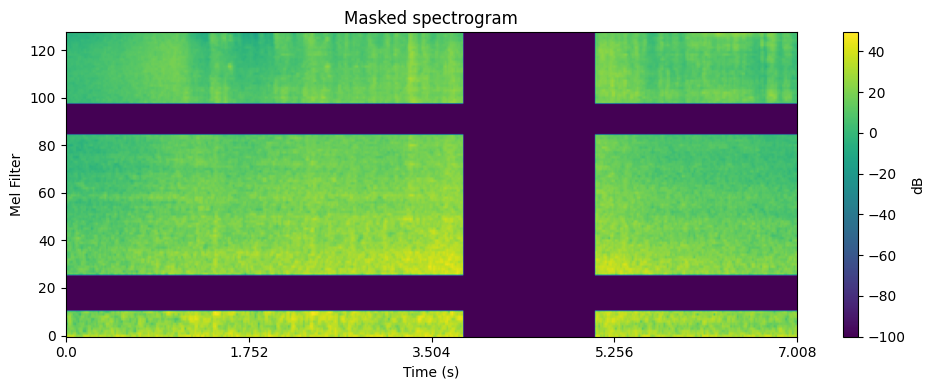

torch.Size([128, 438])
torch.Size([1, 3, 128, 438])


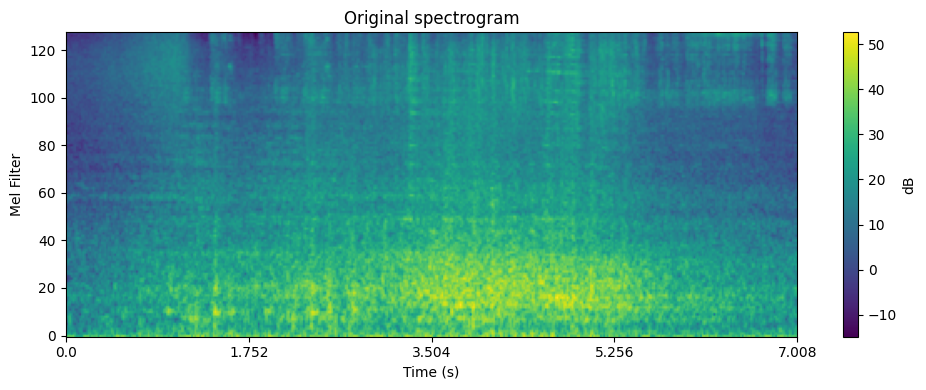

torch.Size([128, 438])
torch.Size([1, 3, 128, 438])


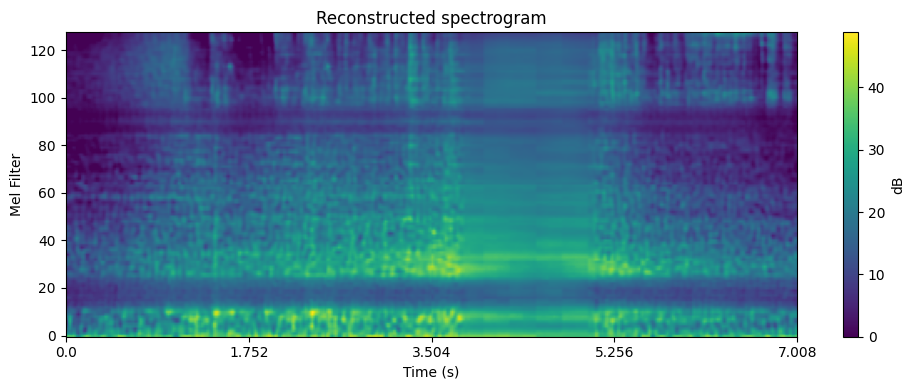

In [14]:

config.batch_size = 1
train_loader, val_loader = DL.create_generators()


#d3elete cuda cache
torch.cuda.empty_cache()
data1, data2 = next(iter(val_loader))
outputs = model(data1)


plot_mel_spectrogram(data1, sample_rate=32000, hop_length=512,name="Masked spectrogram")
plot_mel_spectrogram(data2, sample_rate=32000, hop_length=512,name="Original spectrogram")
plot_mel_spectrogram(outputs, sample_rate=32000, hop_length=512,name="Reconstructed spectrogram")
config.batch_size = 64

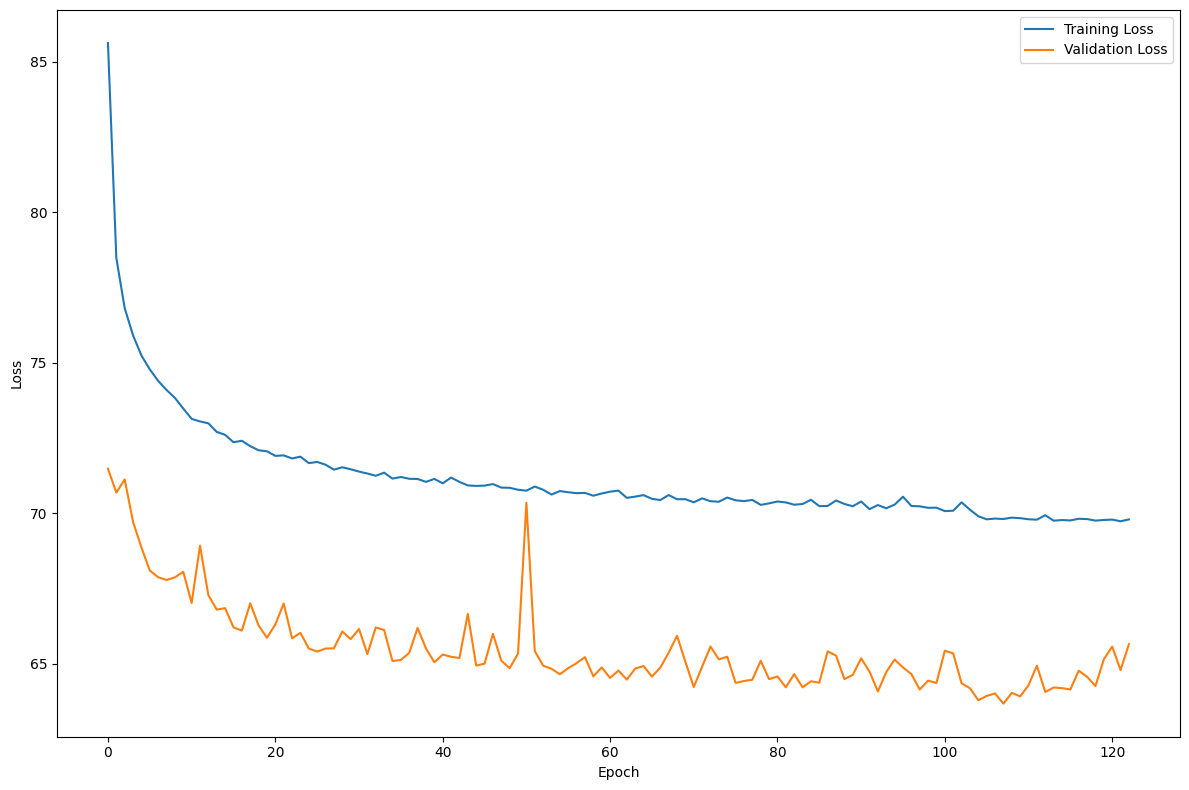

<Figure size 640x480 with 0 Axes>

In [15]:
#plot loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

#save plot
plt.savefig(f'{res_dir}/resNet_autoen_loss.png')